GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 7.4 M  | train
-------------------------------------------------------------
7.4 M     Trainable params
2.4 K     Non-trainable params
7.4 M     Total params
29.748    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 101/101 [00:05<00:00, 18.20it/s, train_loss=0.0256]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 101/101 [00:05<00:00, 18.20it/s, train_loss=0.0256]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.27it/s]


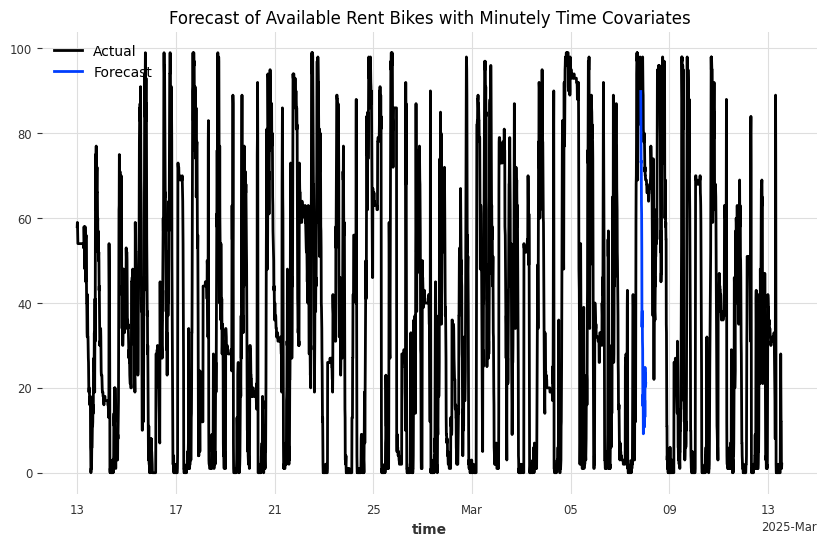

In [27]:
# load data
%matplotlib inline

from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Load the CSV file
file_path = "../../data/prediction/processed_data_all_stations_weather_500101181.csv"
df = pd.read_csv(file_path)

# Convert the 'timestamp' column to datetime
df['time'] = pd.to_datetime(df['timestamp'])

# Add sine and cosine features for the time of day in minutes
df['minute_of_day'] = df['time'].dt.hour * 60 + df['time'].dt.minute
df['sin_minute'] = np.sin(2 * np.pi * df['minute_of_day'] / 1440)  # 1440 minutes in a day
df['cos_minute'] = np.cos(2 * np.pi * df['minute_of_day'] / 1440)

# Create TimeSeries objects
series = TimeSeries.from_dataframe(df, time_col="time", value_cols="available_rent_bikes")
past_covariates = TimeSeries.from_dataframe(df, time_col="time", value_cols=["sin_minute", "cos_minute"])

# Scale the data
target_scaler = Scaler()
covariate_scaler = Scaler()

series_scaled = target_scaler.fit_transform(series)
past_covariates_scaled = covariate_scaler.fit_transform(past_covariates)

# Split the data into training and validation sets
train, val = series_scaled.split_before(0.8)
past_cov_train, past_cov_val = past_covariates_scaled.split_before(0.8)

# Initialize and train the N-BEATS model with covariates
model = NBEATSModel(
    input_chunk_length=60,
    output_chunk_length=30,
    random_state=42
)

model.fit(
    series=train,
    past_covariates=past_cov_train,
    epochs=10,
    verbose=True
)

# Forecast the next 30 minutes
forecast = model.predict(
    n=30,
    series=train,
    past_covariates=past_cov_train,
)

# Scale back the forecast to the original scale
forecast = target_scaler.inverse_transform(forecast)

# Plot the actual data and the forecast
plt.figure(figsize=(10, 6))
series.plot(label="Actual")
forecast.plot(label="Forecast")
plt.legend()
plt.title("Forecast of Available Rent Bikes with Minutely Time Covariates")
plt.show()

In [20]:
from darts.dataprocessing.transformers import Scaler

# Scale the data
scaler = Scaler()
series_scaled = scaler.fit_transform(series)
past_covariates_scaled = scaler.fit_transform(past_covariates)
future_covariates_scaled = scaler.fit_transform(future_covariates)

In [21]:
# Split the data into training and validation sets
train, val = series_scaled.split_before(0.8)
past_cov_train, past_cov_val = past_covariates_scaled.split_before(0.8)
future_cov_train, future_cov_val = future_covariates_scaled.split_before(0.8)

In [24]:
# Initialize and train the N-BEATS model with covariates
model = NBEATSModel(
    input_chunk_length=60,  # Adjust for minutely data (e.g., 60 minutes)
    output_chunk_length=30,  # Predict the next 30 minutes
    random_state=42
)

model.fit(
    series=train,
    past_covariates=past_cov_train,
    #future_covariates=future_cov_train,
    epochs=10,
    verbose=True
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 7.4 M  | train
-------------------------------------------------------------
7.4 M     Trainable params
2.4 K     Non-trainable params
7.4 M     Total params
29.748    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 101/101 [00:05<00:00, 17.22it/s, train_loss=0.0256]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 101/101 [00:05<00:00, 17.22it/s, train_loss=0.0256]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=60, output_chunk_length=30, random_state=42)

In [26]:
# Forecast the next 30 minutes
forecast = model.predict(
    n=30,
    series=train,
    past_covariates=past_cov_train,
    #future_covariates=future_cov_train
)

# Scale back the forecast to the original scale
forecast = scaler.inverse_transform(forecast)

# Plot the actual data and the forecast
plt.figure(figsize=(10, 6))
series.plot(label="Actual")
forecast.plot(label="Forecast")
plt.legend()
plt.title("Forecast of Available Rent Bikes with Minutely Time Covariates")
plt.show()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1:  71%|███████▏  | 72/101 [03:12<01:17,  0.37it/s, train_loss=0.0563]


ValueError: non-broadcastable output operand with shape (30,1) doesn't match the broadcast shape (30,2)